# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.


The data was organized  by Dr. Sina Kashuk at CUSP.
You can get it from the github repo (use the download link to download it live in your notebook). 
It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


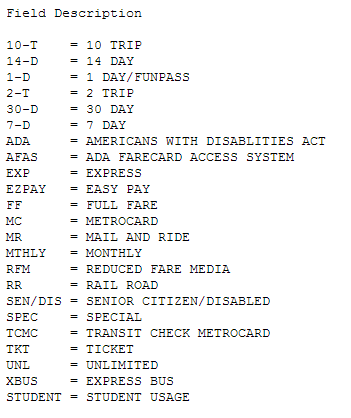

In [1]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

## Each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks from 05/21/2010 to 02/21/2014. 

In [2]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import pylab as pl
import os
import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Task 1: 
### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
### Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.

In [3]:
mtaRides = np.load("MTA_Fare.npy").astype(float)
mtaRides.shape

(600, 23, 194)

In [4]:
mtaRides[mtaRides < 0] = np.nan
week = pd.date_range(start='05/21/2010', end='02/07/2014', freq= 'w')
print(week.shape)
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
#sum time series for all stations
cards = np.nansum(mtaRides, axis=0)
print (cards.shape)
#or for all ride types
stations = np.nansum(mtaRides, axis=1)
print (stations.shape)

(194,)
(23, 194)
(600, 194)


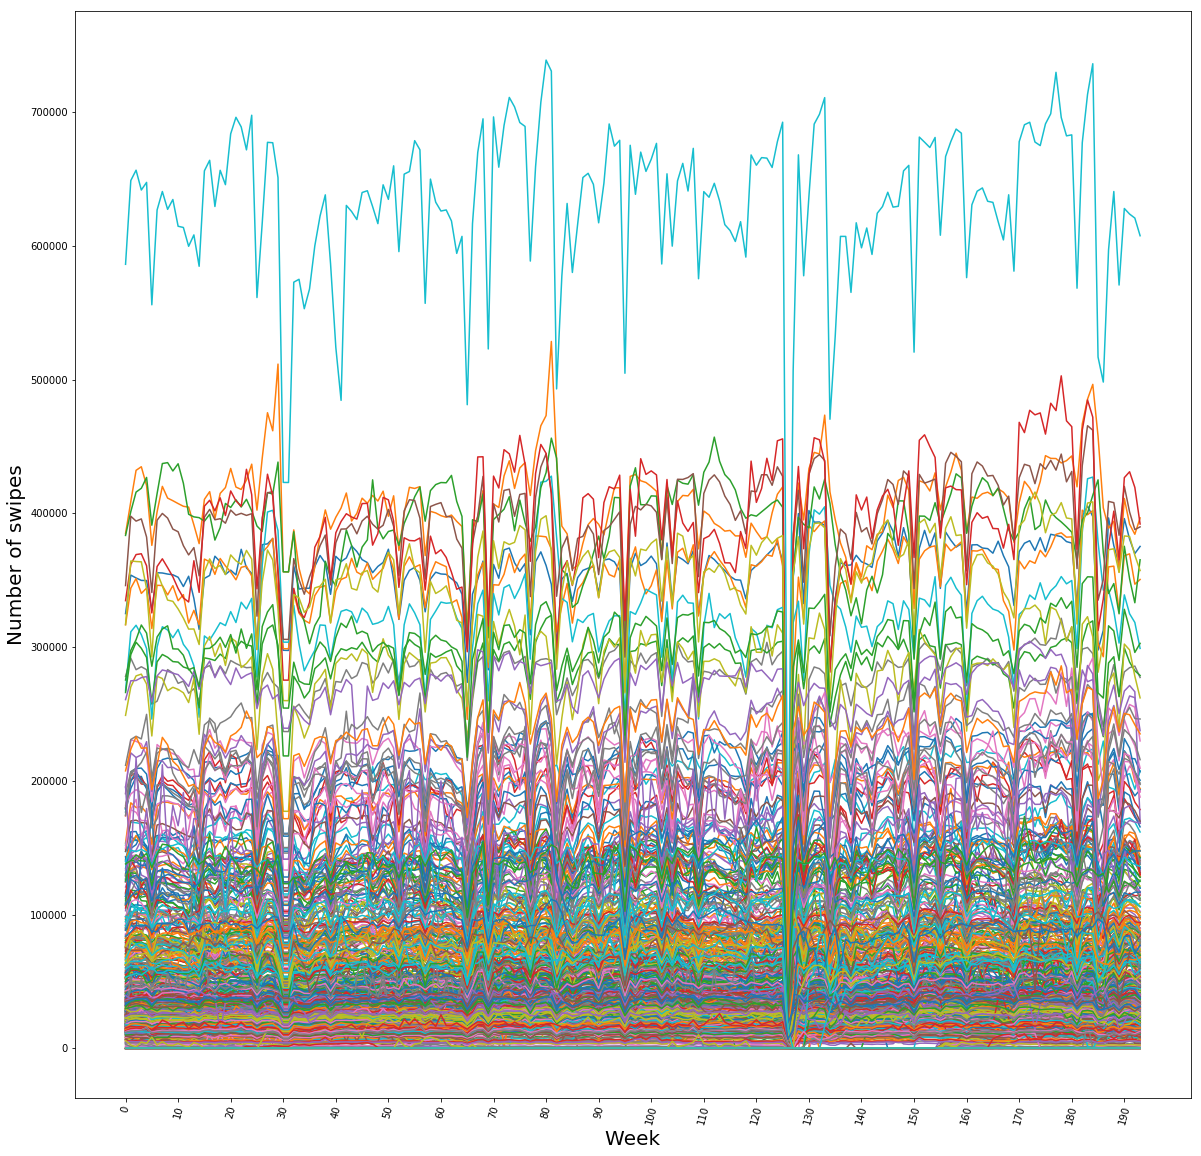

In [5]:
fig = pl.figure(figsize = (20, 20))
for i in arange(0,600):
    pl.plot(stations[i], label=('Station {0}'.format(i)))
pl.xticks(np.arange(0,199,10), rotation=75, fontsize=10)
pl.xlabel('Week', fontsize = 20)
pl.ylabel('Number of swipes', fontsize = 20);

### Figure 1. Time Series of swipes for each MTA station for all Card Holder Types (5/21/10-2/21/14)

In [6]:
weeks_mean = pd.DataFrame(np.nanmean(mtaRides,axis=(0,1)))
weeks_mean.columns = ['mean']
#finding the z-score as z = (x – μ) / σ
weeks_mean['z-score']=abs((weeks_mean['mean'].mean()-weeks_mean['mean'])/weeks_mean['mean'].std())
weeks_mean.sort(['z-score'],ascending=False)[0:1]

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,mean,z-score
126,493.259546,8.725996


In [7]:
#finding the date with a significant drop
week[126]

Timestamp('2012-10-21 00:00:00', offset='W-SUN')

### The preiod of a significant drop in swipes is October 21-27, 2012. This is due to Hurricane Sandy.
More informdation available here:

https://cityroom.blogs.nytimes.com/2012/10/27/m-t-a-chief-announces-storm-plan-for-subways-buses-and-commuter-trains/?_r=0

## Task 2: 
### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

In [8]:
cards_pd = pd.DataFrame(cards.T, index = week.date)
cards_pd = cards_pd.T
cards_pd.index = ridetype
cards_pd.head()

,2010-05-23,2010-05-30,2010-06-06,2010-06-13,2010-06-20,2010-06-27,2010-07-04,2010-07-11,2010-07-18,2010-07-25,...,2013-12-01,2013-12-08,2013-12-15,2013-12-22,2013-12-29,2014-01-05,2014-01-12,2014-01-19,2014-01-26,2014-02-02
10t,11494615.0,12526859.0,12766627.0,12653675.0,12809694.0,11429783.0,12346877.0,12576759.0,12437115.0,12431257.0,...,14604028.0,11344945.0,11223430.0,12864865.0,12904811.0,11932970.0,13139360.0,13189610.0,12500756.0,12459947.0
14d,530524.0,583533.0,586194.0,562602.0,548858.0,455691.0,518187.0,513412.0,512192.0,522569.0,...,781529.0,596341.0,518956.0,664531.0,744990.0,613294.0,713717.0,695134.0,670228.0,679497.0
1d,47801.0,51486.0,51636.0,52063.0,51153.0,46852.0,48963.0,49629.0,49030.0,50376.0,...,62658.0,50820.0,45153.0,56129.0,60429.0,51664.0,57208.0,58771.0,56525.0,55192.0
2t,186551.0,199229.0,199668.0,196389.0,194883.0,175648.0,188467.0,188090.0,186822.0,190528.0,...,193268.0,164607.0,148652.0,177885.0,193547.0,168932.0,189564.0,184239.0,180029.0,179363.0
30d,46808.0,64353.0,56994.0,37429.0,35210.0,46849.0,60225.0,47439.0,32084.0,52171.0,...,56671.0,22623.0,25301.0,67713.0,64867.0,43426.0,47804.0,61101.0,59400.0,46859.0


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


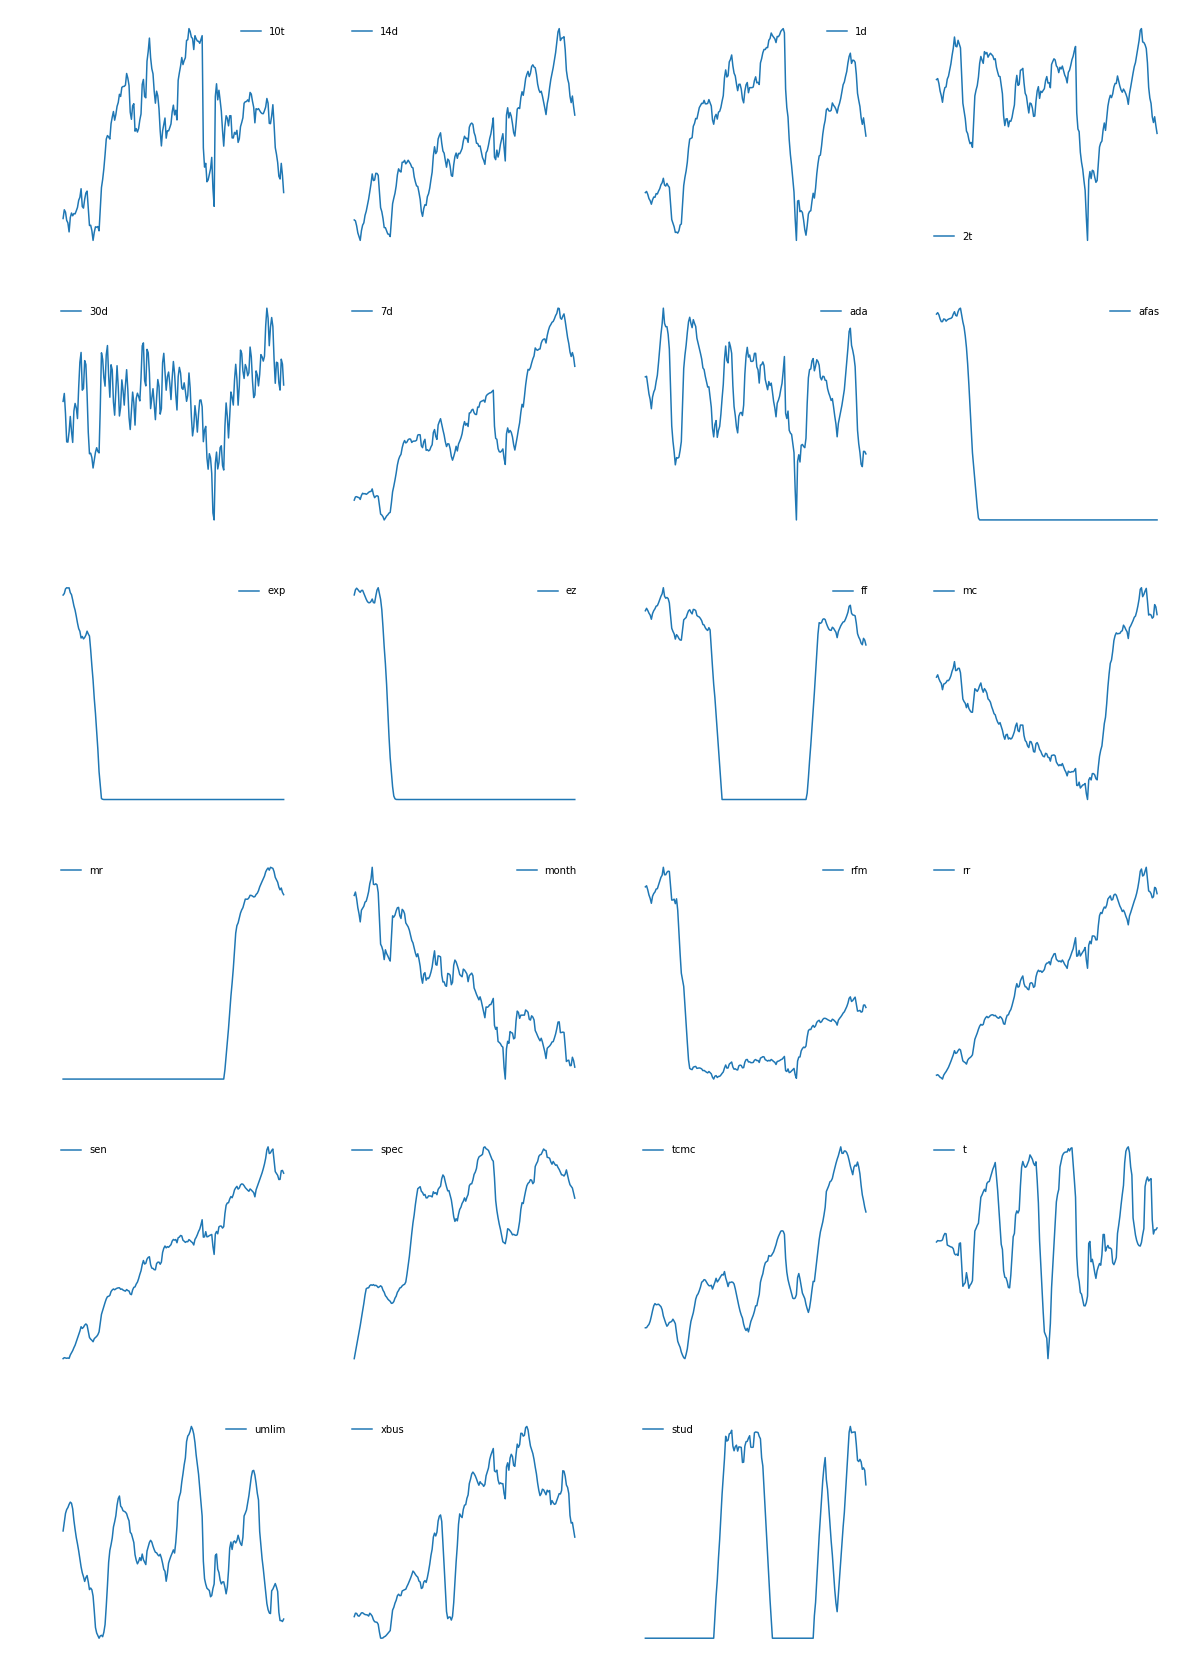

In [9]:
fig = pl.figure(figsize = (20, 30))
ax = []
for i in range(len(cards)):
    ax.append(fig.add_subplot(6, 4, i+1))
    ax[i].plot(pd.rolling_mean(cards[i], 10), label=('{0}'.format(ridetype[i])))
    ax[i].axis('off')
    ax[i].legend(fontsize=10, loc='best', frameon=False)

### Figure 2. Rolling Mean time series of total swipes for each MTA cardholder type (5/21/10-2/21/14)

Given above 23 subplots one can identify the trend by different card type. Whether it stationary or have an increase/decrease in popularity.


Let us use the Augmented Dickey-Fuller unit root test to determine stationarity of stations.

Null Hypothesis: There is a unit root. Therefore MTA ride type time series is non-stationary.

alpha = 0.05

Check if the p-value is less than 5%, then reject the null hypothesis

In [10]:
#sm.tsa.adfuller?

In [11]:
cards_adf = {}

for i in range(len(cards)): 
    if sm.tsa.adfuller(cards[i])[0] > sm.tsa.adfuller(cards[i])[4]['10%']:
        cards_adf[ridetype[i]] = 'nonstationary'
        print ('{0}: nonstationary\n'.format(ridetype[i]))
    else:
        cards_adf[ridetype[i]] = 'stationary'
        print ('{0}: stationary\n'.format(ridetype[i]))
    print ('with p-value = {0}\n'.format(sm.tsa.adfuller(cards[i])[1]))
cards_adf;

10t: stationary

with p-value = 1.1433626719252372e-20

14d: nonstationary

with p-value = 0.2229080909836994

1d: nonstationary

with p-value = 0.23279389090904606

2t: stationary

with p-value = 2.987132142606603e-17

30d: stationary

with p-value = 0.0017714896955103206

7d: nonstationary

with p-value = 0.5258732735319307

ada: stationary

with p-value = 2.662642825249212e-16

afas: stationary

with p-value = 0.08688102818393584

exp: stationary

with p-value = 0.032966506087813714

ez: nonstationary

with p-value = 0.11846047129654408

ff: nonstationary

with p-value = 0.5361848085318555

mc: nonstationary

with p-value = 0.8721981559165106

mr: nonstationary

with p-value = 0.9312441323621019

month: nonstationary

with p-value = 0.5486655832283038

rfm: nonstationary

with p-value = 0.2316933520107562

rr: nonstationary

with p-value = 0.7609073600426849

sen: nonstationary

with p-value = 0.7388960719185693

spec: stationary

with p-value = 0.07203561616321617

tcmc: stationary

In [12]:
#nonstationary card types
print ('Non-stationary series:')
cards_adf_nonst = []
for i in range(len(cards_adf)):
    if cards_adf[ridetype[i]] == 'nonstationary':
        cards_adf_nonst.append(ridetype[i])
        print (ridetype[i])
        
#stationary card types
print ('Stationary series:')
cards_adf_st = []
for i in range(len(cards_adf)):
    if cards_adf[ridetype[i]] == 'stationary':
        cards_adf_st.append(ridetype[i])
        print (ridetype[i])

Non-stationary series:
14d
1d
7d
ez
ff
mc
mr
month
rfm
rr
sen
xbus
Stationary series:
10t
2t
30d
ada
afas
exp
spec
tcmc
t
umlim
stud


Looking at the ratio in the first and last 10 weeks period for Stationary and Non-stationary stations:

In [13]:
print ('Non-stationary series:')
for i in range(len(ridetype)):
    for j in range(len(cards_adf_nonst)):
        if cards_adf_nonst[j] == ridetype[i]:
            print ('{0}: ratio = {1:.2f}'
                   .format(ridetype[i],(np.sum(cards[i][183:-1]))/(np.sum(cards[i][0:10]))))

Non-stationary series:
14d: ratio = 1.27
1d: ratio = 1.13
7d: ratio = 1.42
ez: ratio = 0.00
ff: ratio = 0.84
mc: ratio = 1.24
mr: ratio = 25082.72
month: ratio = 0.59
rfm: ratio = 0.66
rr: ratio = 2.64
sen: ratio = 2.94
xbus: ratio = 1.72


In [14]:
print ('Stationary series:')
for i in range(len(ridetype)):
    for j in range(len(cards_adf_st)):
        if cards_adf_st[j] == ridetype[i]:
            print ('{0}: ratio = {1:.2f}'
                   .format(ridetype[i],(np.sum(cards[i][183:-1]))/(np.sum(cards[i][0:10]))))

Stationary series:
10t: ratio = 1.04
2t: ratio = 0.94
30d: ratio = 1.08
ada: ratio = 0.90
afas: ratio = 0.00
exp: ratio = 0.00
spec: ratio = 72.32
tcmc: ratio = 1.55
t: ratio = 1.02
umlim: ratio = 0.80
stud: ratio = inf


Card types with increase:
- mr (2508272%)
- spec (7232%)
- sen (294%)
- rr (264%)
- xbus (172%)
- tcmc (155%)
- 7d (142%)
- 14d (127%)

## Task 3:
### Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [15]:
periodicity = {}
for i in range(len(stations)):
    periodicity[i] = np.abs(np.fft.rfft(stations[i])[4])
    
station_periodicity = sorted(periodicity.items())
print('MTA Stations with annual trends')
sorted(station_periodicity, key= lambda x: x[1],reverse=True)[0:4]

MTA Stations with annual trends


[(0, 2980160.6355953491),
 (194, 2950388.929214194),
 (150, 2931895.8769513383),
 (327, 2402218.5809588572)]

In [16]:
stations_pd = pd.DataFrame(week)[0].values

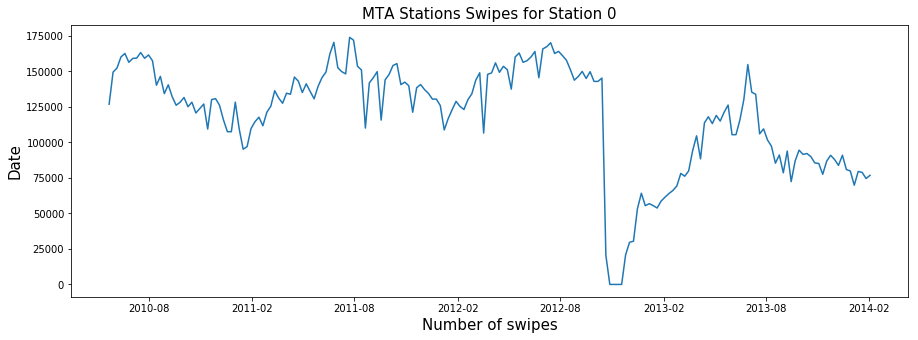

In [17]:
fig=plt.figure(figsize=(15,5))
plt.plot(stations_pd, stations[0])
plt.title('MTA Stations Swipes for Station 0', fontsize = 15);
plt.xlabel('Number of swipes', fontsize = 15)
plt.ylabel('Date', fontsize = 15);

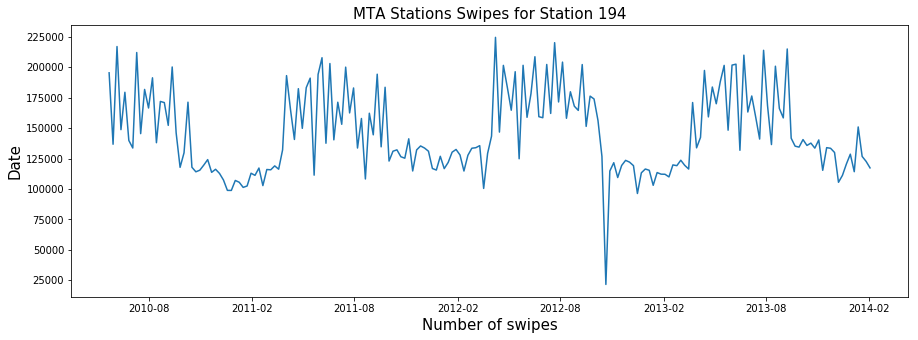

In [18]:
fig=plt.figure(figsize=(15,5))
plt.plot(stations_pd, stations[194])
plt.title('MTA Stations Swipes for Station 194', fontsize = 15);
plt.xlabel('Number of swipes', fontsize = 15)
plt.ylabel('Date', fontsize = 15);

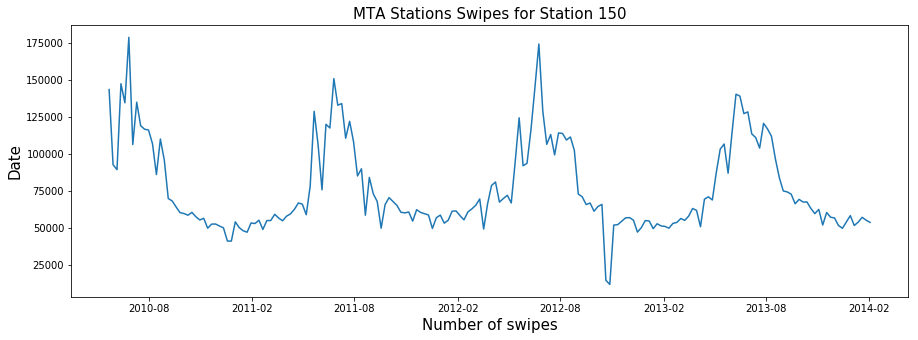

In [19]:
fig=plt.figure(figsize=(15,5))
plt.plot(stations_pd, stations[150])
plt.title('MTA Stations Swipes for Station 150', fontsize = 15);
plt.xlabel('Number of swipes', fontsize = 15)
plt.ylabel('Date', fontsize = 15);

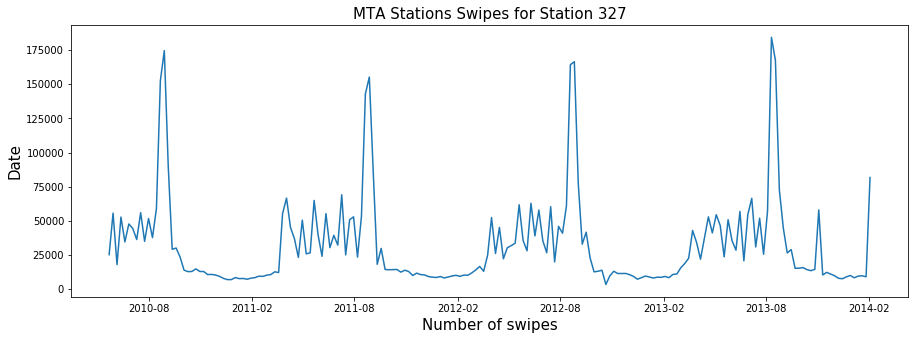

In [20]:
fig=plt.figure(figsize=(15,5))
plt.plot(stations_pd, stations[327])
plt.title('MTA Stations Swipes for Station 327', fontsize = 15);
plt.xlabel('Number of swipes', fontsize = 15)
plt.ylabel('Date', fontsize = 15);

### The above figures of four MTA Stations show an annual periodicity. We observe peaks during Summer period, following drops in colder  months.

## EXTRA CREDIT: Cluster.

### Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis).

In [21]:
tots = mtaRides.transpose(2,0,1).reshape(mtaRides.shape[2], mtaRides.shape[1]*mtaRides.shape[0]).T
tots.shape

(13800, 194)

In [22]:
tots = tots[tots.std(1)>0]

In [23]:
vals = ((tots.T - tots.mean(1))/tots.std(1)).T
vals.shape

(7660, 194)

Text(0.5,1,'Scatter plot of MTA Stations Swipes time series')

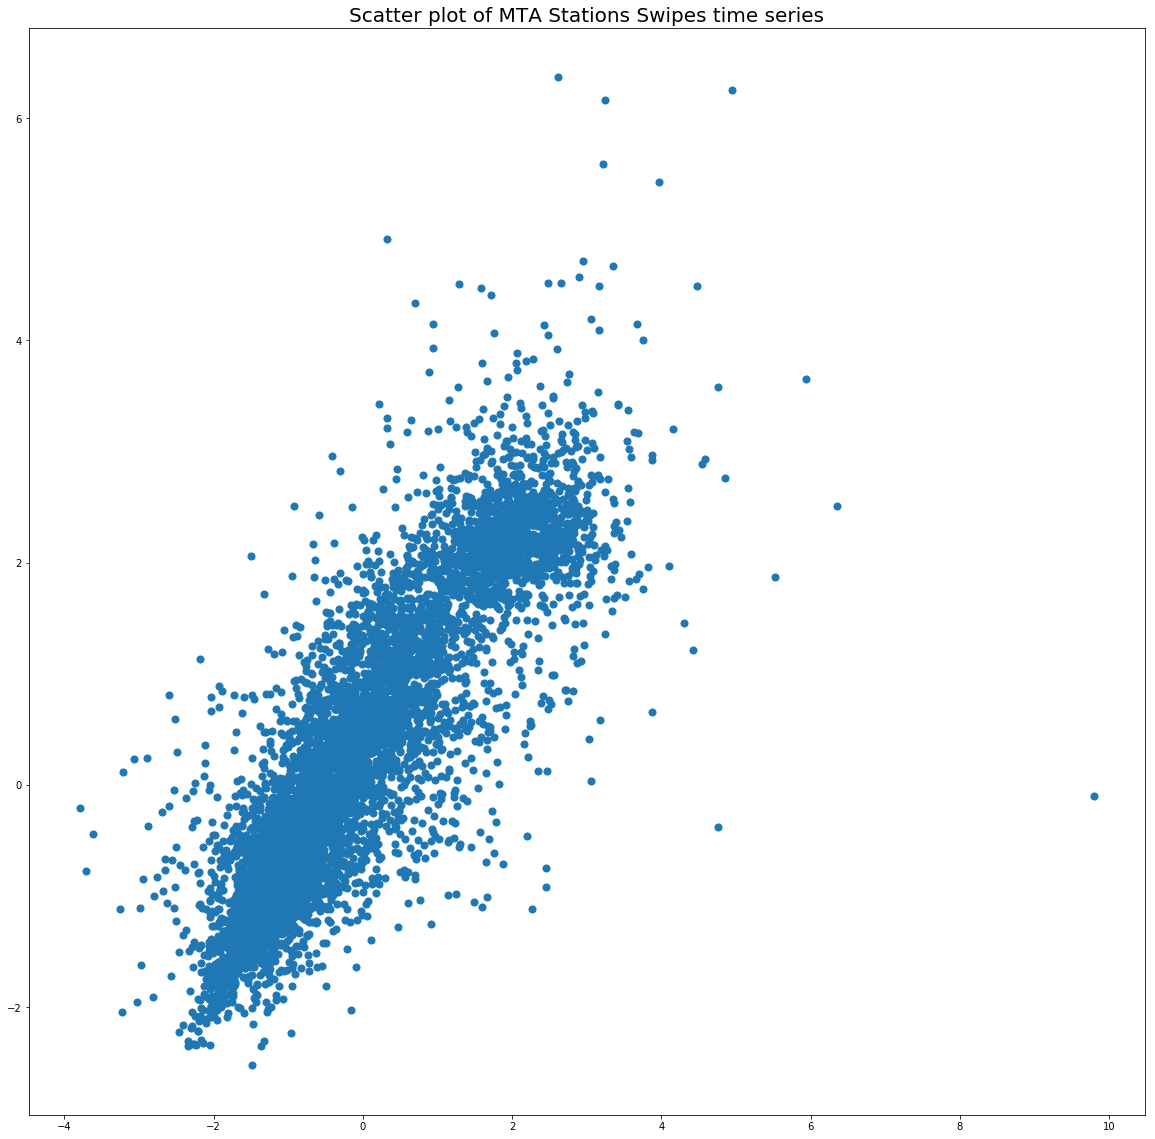

In [24]:
plt.figure(figsize=(20, 20))
plt.scatter(vals[:, 0], vals[:, 1], s=50);
pl.title('Scatter plot of MTA Stations Swipes time series', fontsize=20)

In [25]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3)
km.fit(vals)
y_km = km.predict(vals)

Text(0.5,1,'Three clusters of MTA Stations Swipes time series')

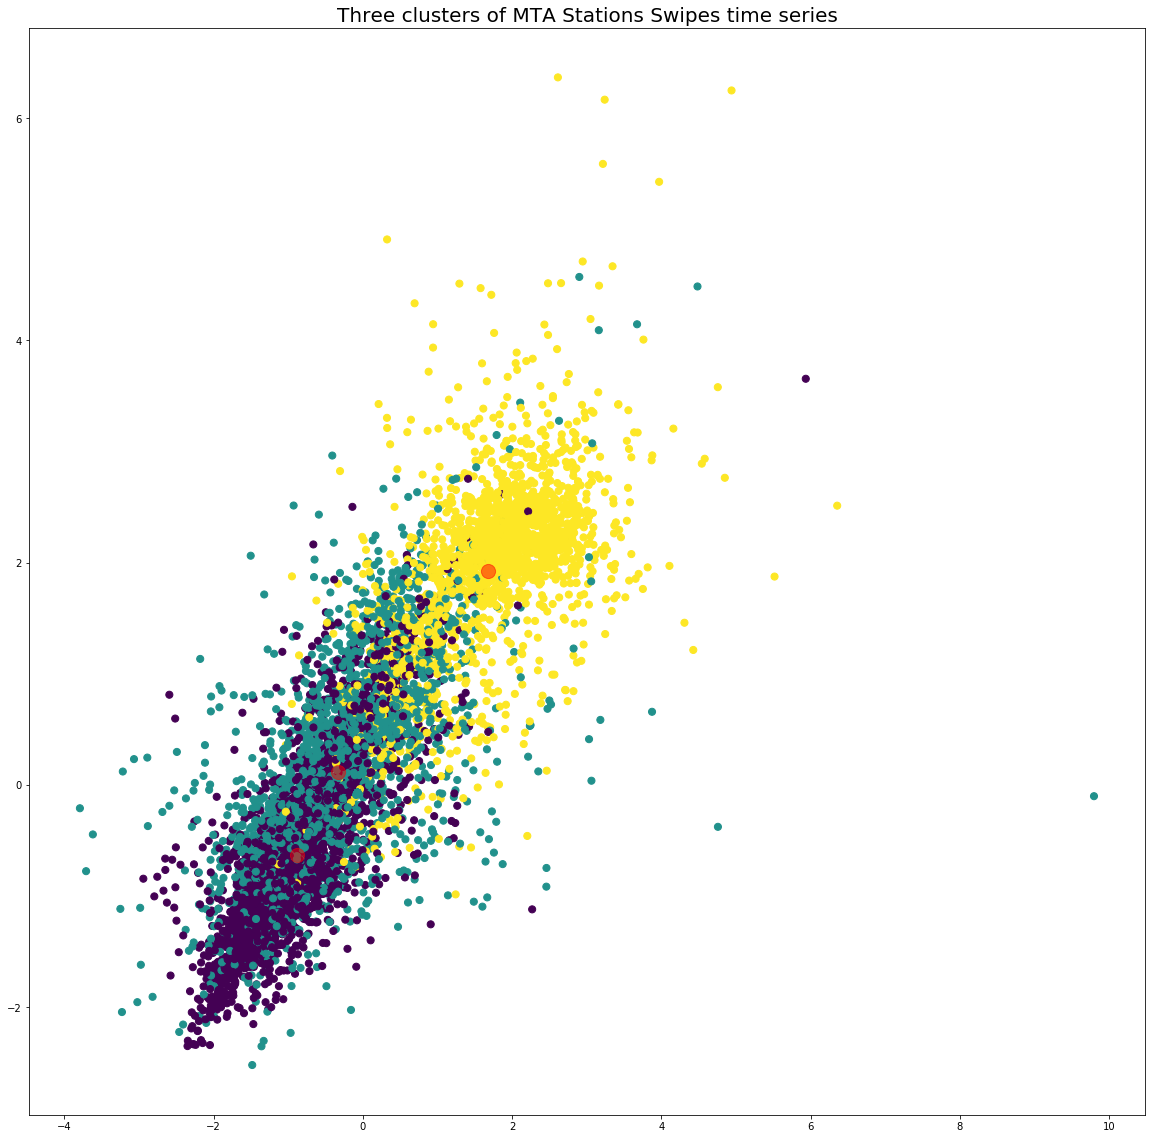

In [26]:
plt.figure(figsize=(20, 20))
plt.scatter(vals[:, 0], vals[:, 1], c=y_km, s=50, cmap='viridis')

centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);
pl.title('Three clusters of MTA Stations Swipes time series', fontsize=20)

In [31]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [28]:
Z = linkage(vals, 'ward')

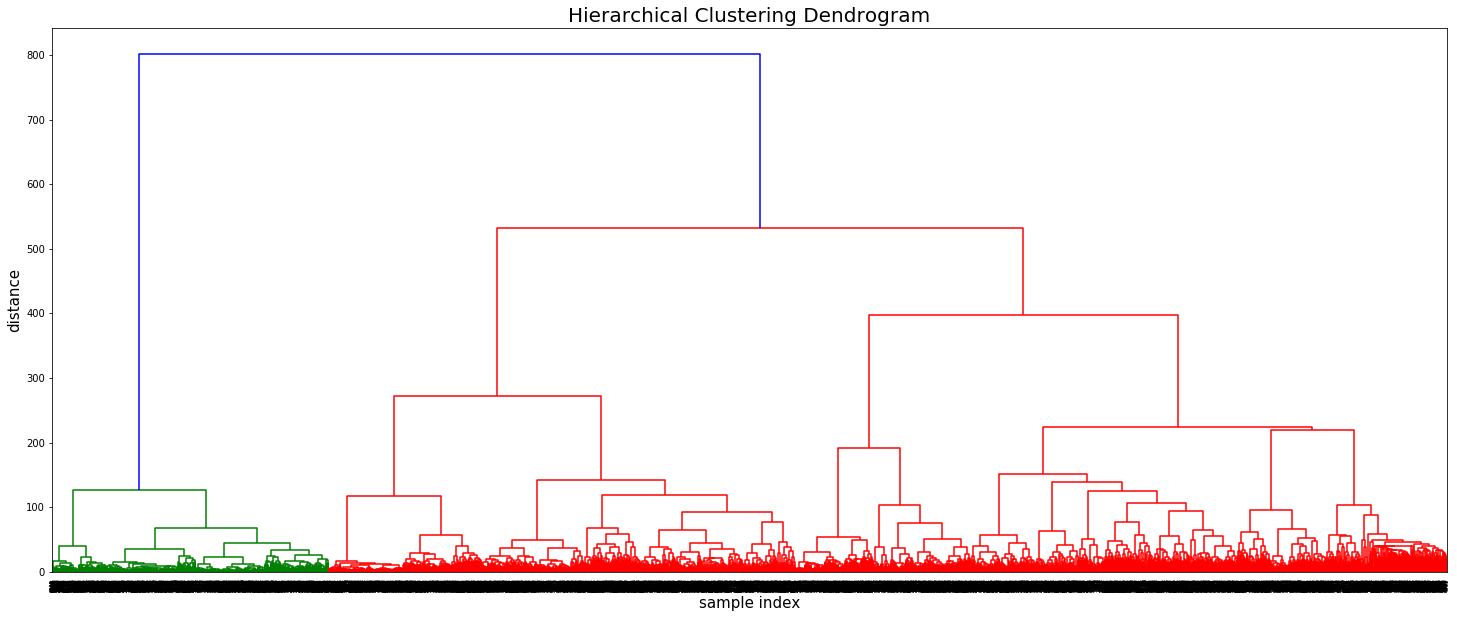

In [32]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram', fontsize = 20)
plt.xlabel('sample index', fontsize = 15)
plt.ylabel('distance', fontsize = 15)
dendrogram(
    Z,
    leaf_rotation=90.
)
plt.show()

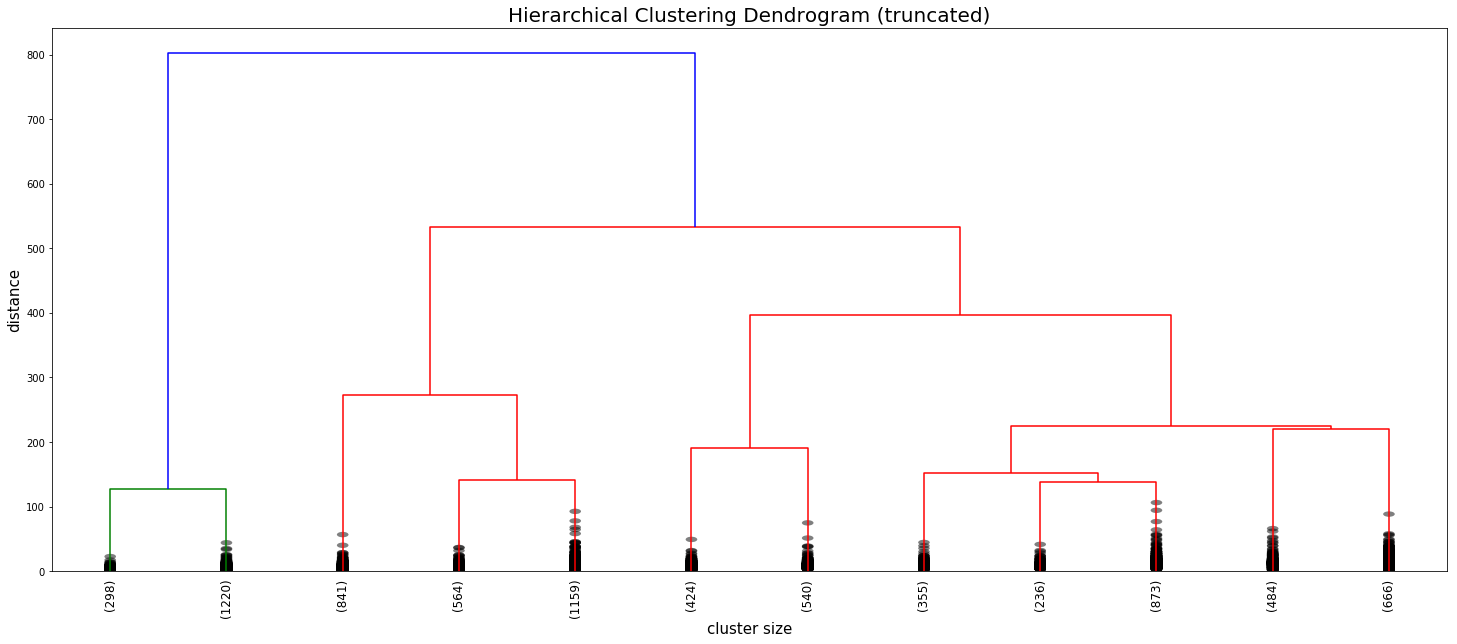

In [33]:
# show only the last p merged clusters
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram (truncated)', fontsize = 20)
plt.xlabel('cluster size', fontsize = 15)
plt.ylabel('distance', fontsize = 15)
dendrogram(
    Z,
    truncate_mode='lastp',  
    p=12, 
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
)
plt.show()